# Latent Heat Decomposition
This notebook uses output from Isca to try and reconstruct the latent and sensible heat fluxes.

In [85]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile, sphum_sat
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat
from isca_tools.utils.constants import c_p, R, R_v, kappa, L_v
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import optimize

In [47]:
# Load dataset
exp_name = 'aquaplanet/no_wishe/test'
ds_all = isca_tools.load_dataset(exp_name).sel(pfull=np.inf, method='nearest')      # only load in atmos level closest to surface
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value

In [148]:
loc_use = {'lat': 0, 'lon': 100}
ds = ds_all.sel(lat=loc_use['lat'], lon=loc_use['lon'], method='nearest').load()

## Equation vs Isca Output Comparison
The [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L598) used for latent heat flux by Isca is:
$LH = L_v C_q\rho |v|(q_{surf} - q_{atm})$
where $C_q$ is the moisture drag coefficient, $\rho$ is the lowest level air density, $|v|$ is the lowest level horizontal wind speed, $q_{surf} = q_{sat}(T_{surf})$ is the saturation specific humidity at the surface, $q_{atm}$ is the lowest level specific humidity.

The match between the output by Isca, and the computation using this equation is pretty close.

The [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L583) used for sensible heat flux by Isca is:
$SH = c_p C_t\rho |v|\bigg(T_{surf} - T_{atm}\bigg(\frac{p_{surf}}{p_{atm}}\bigg)^{\kappa}\bigg)$

This line is shown in blue on the right below, and it does differ from the Isca output in black quite significantly. However, the orange line shows a much better match at high latitudes and uses the equation: 
$SH = c_p C_t\rho |v|\bigg(T_{surf} - T_{atm}\bigg)$
I.e. atmospheric temperature rather than potential temperature. At low latitudes though, the blue line seems better.

Text(0.5, 1.0, 'Sensible Heat')

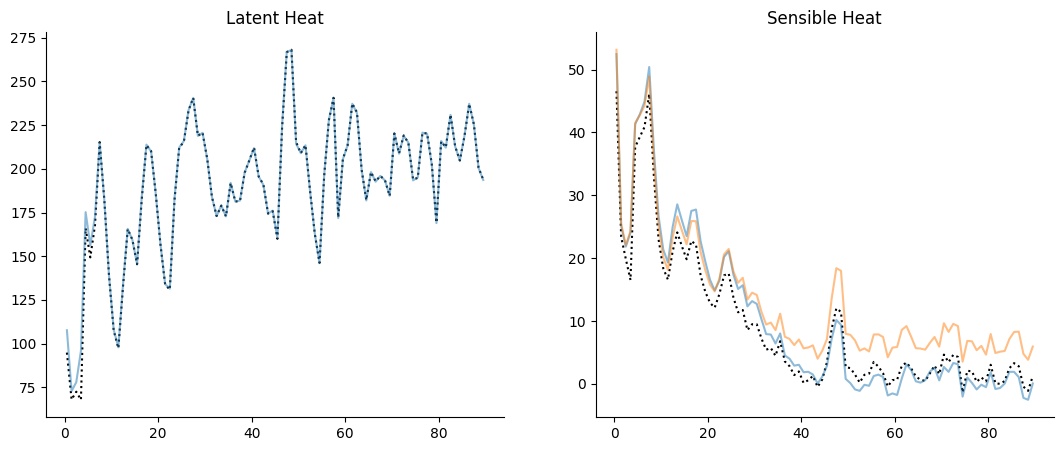

In [155]:
flux_lh_manual = ds.drag_q * ds.w_atm * ds.rho * (ds.q_surf - ds.q_atm) * L_v
flux_sh_manual = ds.drag_t * ds.w_atm * ds.rho * (ds.t_surf - ds.temp * (ds.ps/(ds.pfull*100))**kappa) * c_p
flux_sh_manual2 = ds.drag_t * ds.w_atm * ds.rho * (ds.t_surf - ds.temp) * c_p

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(1,2, figsize=(13, 5), sharex=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[0].plot(ds.time, ds.flux_lhe, color='k', linestyle=':')
ax[0].plot(ds.time, flux_lh_manual, alpha=0.5)
ax[0].set_title('Latent Heat')

ax[1].plot(ds.time, ds.flux_t, color='k', linestyle=':')
ax[1].plot(ds.time, flux_sh_manual, alpha=0.5)
ax[1].plot(ds.time, flux_sh_manual2, alpha=0.5)
ax[1].set_title('Sensible Heat')

### Density
There seems to be quite a significant difference between the density output by Isca and that obtained using the [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L579) used by Isca. 

But this may just be because the scale of the y-axis is very small.

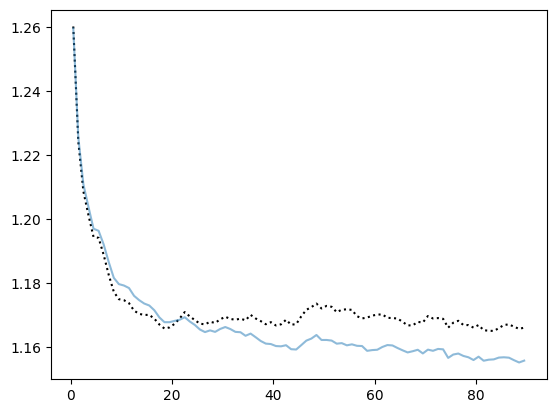

In [150]:
def get_virtual_temp(temp,sphum):
    d622 = R/R_v
    d378 = 1 - d622
    d608   = d378/d622
    return (1+d608 * sphum) * temp

def density_calc(pressure, temp, sphum):
    return pressure / (R * get_virtual_temp(temp, sphum))

plt.plot(ds.time, ds.rho, color='k', linestyle=':')
plt.plot(ds.time, density_calc(ds.pfull*100, ds.temp, ds.sphum), alpha=0.5)

### Wind Speed
There is a very good match between the wind speed output by Isca, and then computed from the individual $u$ and $v$ components: $\sqrt{u^2 + v^2}$.

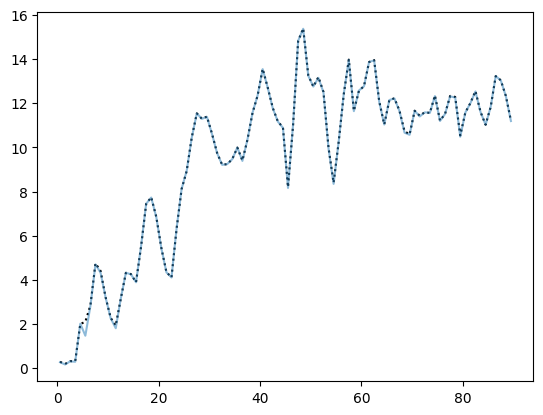

In [151]:
plt.plot(ds.time, ds.w_atm, color='k', linestyle=':')
plt.plot(ds.time, np.sqrt(ds.ucomp**2 + ds.vcomp**2), alpha=0.5)

### Specific Humidity
There is an almost perfect match between the specific humidities used in the Isca calculation (`q_surf` and `q_atm`), and those computed from the normal Isca outputs ($q_{sphum}$(`t_surf`, `ps`) and `sphum`).

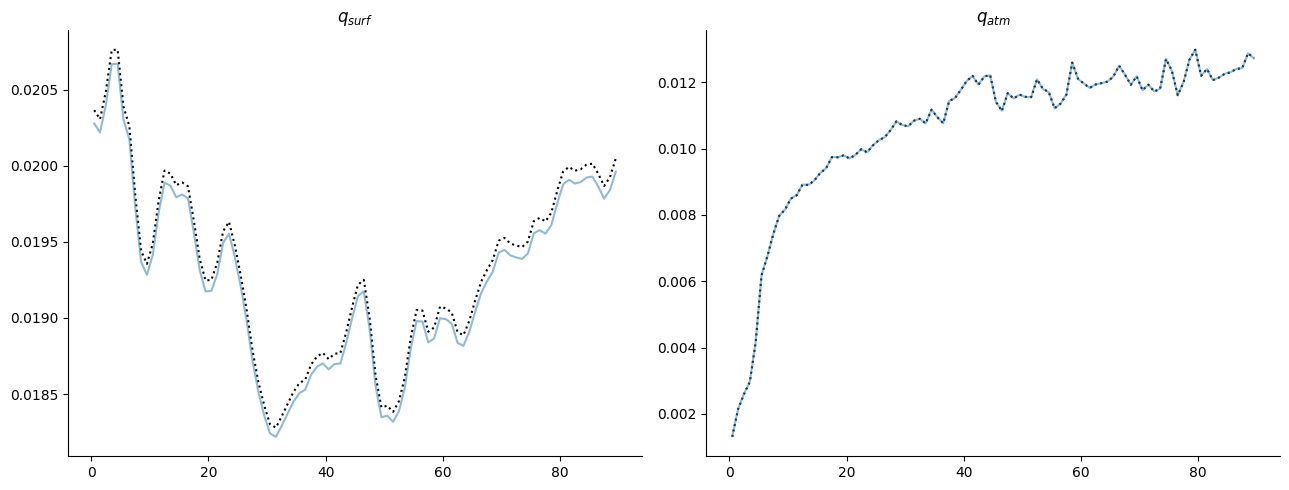

In [153]:
fig, ax = plt.subplots(1,2, figsize=(13, 5), sharex=True)
ax[0].spines[['top', 'right']].set_visible(False)
ax[1].spines[['top', 'right']].set_visible(False)
ax[0].plot(ds.time, ds.q_surf, color='k', linestyle=':')
ax[0].plot(ds.time, sphum_sat(ds.t_surf, ds.ps), alpha=0.5)
ax[0].set_title('$q_{surf}$')
ax[1].plot(ds.time, ds.q_atm, color='k', linestyle=':')
ax[1].plot(ds.time, ds.sphum, alpha=0.5)
ax[1].set_title('$q_{atm}$')
plt.tight_layout()